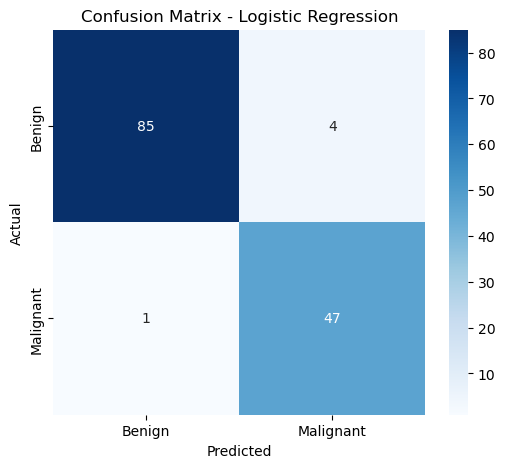

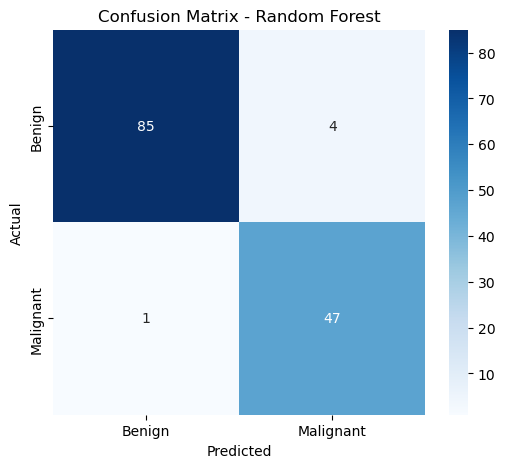

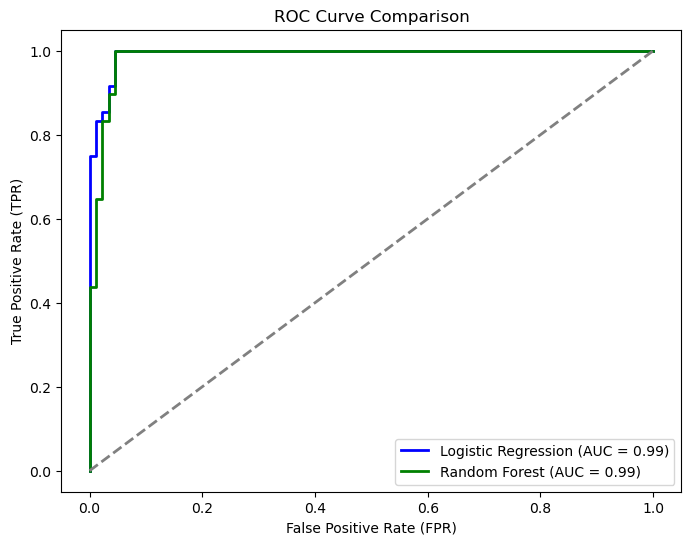

Best parameters for Logistic Regression: {'C': 0.1}
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
                 Model  Accuracy       AUC
0  Logistic Regression  0.963504  0.992743
1        Random Forest  0.963504  0.986657


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import os

# Read data from the pandas network resource
df =  pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data",
                   names = ['Sample_code_number','Clump_Thickness','Uniformity_Of_Cell_Size',
                            'Uniformity of Cell Shape','Marginal Adhesion','Single_Epithelial_Cell_Size',
                            'Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','Class'])

# Remove ID column
df.drop('Sample_code_number', axis=1, inplace=True)

# Convert "?" in 'Bare_Nuclei' to NaN and change dtype to float
df['Bare_Nuclei'] = pd.to_numeric(df['Bare_Nuclei'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Convert target variable (2 -> 0 for benign, 4 -> 1 for malignant)
df['Class'] = df['Class'].map({2: 0, 4: 1}).astype(int)

# Check correlation and remove highly correlated features
correlation_matrix = df.corr()
high_correlation_features = set()
correlation_threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            high_correlation_features.add(colname)

df.drop(columns=high_correlation_features, inplace=True)

# Split data into train-test sets
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning for Logistic Regression
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_grid = GridSearchCV(LogisticRegression(), log_reg_params, cv=5, scoring='roc_auc')
log_reg_grid.fit(X_train_scaled, y_train)
best_log_reg = log_reg_grid.best_estimator_

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='roc_auc')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Predictions
y_pred_log = best_log_reg.predict(X_test_scaled)
y_pred_rf = best_rf.predict(X_test)

# Evaluate models
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Confusion Matrices
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# ROC Curve for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, best_log_reg.predict_proba(X_test_scaled)[:, 1])
roc_auc_log = auc(fpr_log, tpr_log)

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Display Results
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [accuracy_log, accuracy_rf],
    "AUC": [roc_auc_log, roc_auc_rf]
})

print("Best parameters for Logistic Regression:", log_reg_grid.best_params_)
print("Best parameters for Random Forest:", rf_grid.best_params_)
print(results)
